In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, LeakyReLU  
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
def load_images(image_dir, target_size=(128, 128)):
    images = []
    image_names = []
    for file_name in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, file_name)).convert('YCbCr')
        img = img.resize(target_size)
        y, _, _ = img.split()  
        images.append(np.array(y, dtype=np.float32) / 255.0)  
        image_names.append(file_name)
    return np.array(images), image_names

In [3]:

original_image_dir = r'C:\Users\ADMIN\Desktop\ethos\ndata'
degraded_image_dir = r'C:\Users\ADMIN\Desktop\ethos\nddata'

original_images, _ = load_images(original_image_dir)
degraded_images, _ = load_images(degraded_image_dir)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(degraded_images, original_images, test_size=0.2, random_state=42)


X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)
y_train = y_train.reshape(-1, 128, 128, 1)
y_val = y_val.reshape(-1, 128, 128, 1)


In [22]:
from keras.layers import Input, Conv2D, Add, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam

def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    

    x = Conv2D(64, (9, 9), activation='relu', padding='same')(inputs)

    for _ in range(16):
        residual = Conv2D(64, (3, 3), padding='same')(x)
        residual = BatchNormalization()(residual)
        residual = Activation('relu')(residual)
        residual = Conv2D(64, (3, 3), padding='same')(residual)
        residual = BatchNormalization()(residual)
        x = Add()([x, residual])

   
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(1, (5, 5), activation='tanh', padding='same')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')
    
    return model

input_shape = (128, 128, 1)
generator = build_generator(input_shape)


In [23]:
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    outputs = tf.keras.layers.Activation('sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')
    
    return model

discriminator = build_discriminator((128, 128, 1))



In [40]:
output_shape = discriminator.output_shape
print(output_shape)


(None, 128, 128, 1)


In [32]:

discriminator.trainable = False
combined_input = Input(shape=input_shape)
generated_image = generator(combined_input)
validity = discriminator(generated_image)
combined_model = Model(combined_input, [validity, generated_image])
combined_model.compile(optimizer=Adam(learning_rate=1e-4), 
                        loss=['binary_crossentropy', 'mean_squared_error'], 
                        loss_weights=[1e-3, 1])


epochs = 50
batch_size = 3
train_steps = len(X_train) // batch_size

In [33]:
for layer in combined_model.layers:
    print(layer.name, layer.trainable)


input_11 True
model_6 True
model_7 False


In [34]:
combined_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 model_6 (Functional)        (None, 128, 128, 1)       1307521   
                                                                 
 model_7 (Functional)        (None, 128, 128, 1)       1558017   
                                                                 
Total params: 2,865,538
Trainable params: 1,303,425
Non-trainable params: 1,562,113
_________________________________________________________________


In [29]:
import os


checkpoint_dir = "checkpoints23"  
os.makedirs(checkpoint_dir, exist_ok=True)

In [35]:
import os
import numpy as np

patience = 6
best_g_loss = float('inf')
best_d_loss = float('inf')

for epoch in range(epochs):
    epoch_d_loss = []
    for step in range(train_steps):
        low_res_batch = X_train[step * batch_size:(step + 1) * batch_size]
        high_res_batch = y_train[step * batch_size:(step + 1) * batch_size]
        
        generated_images = generator.predict(low_res_batch)
        
        
        real_labels = np.ones((batch_size, 128, 128, 1))  
        fake_labels = np.zeros((batch_size, 128, 128, 1))  
        
        d_loss_real = discriminator.train_on_batch(high_res_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        
        epoch_d_loss.append((d_loss_real + d_loss_fake) / 2)
        

        g_loss = combined_model.train_on_batch(low_res_batch, [real_labels, high_res_batch])
        
        if step % 10 == 0:
            print(f"Epoch: {epoch + 1}/{epochs}, Step: {step + 1}/{train_steps}, "
                  f"D Loss Real: {d_loss_real:.4f}, D Loss Fake: {d_loss_fake:.4f}, "
                  f"G Loss: {g_loss[0]:.4f}")

    avg_d_loss = np.mean(epoch_d_loss)
    if g_loss[0] < best_g_loss:
        best_g_loss = g_loss[0]
        print(f"New best generator loss: {best_g_loss:.4f}")
        
    if avg_d_loss < best_d_loss:
        best_d_loss = avg_d_loss
        print(f"New best discriminator loss: {best_d_loss:.4f}")

    generator.save(os.path.join(checkpoint_dir, f"generator_epoch_{epoch + 1}.h5"))
    discriminator.save(os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch + 1}.h5"))


1/1 [==============================] - 0s 20ms/step
Epoch: 1/50, Step: 1/133, D Loss Real: 0.5125, D Loss Fake: 0.9681, G Loss: 0.1780
1/1 [==============================] - 0s 14ms/step
Epoch: 1/50, Step: 11/133, D Loss Real: 0.6447, D Loss Fake: 0.5656, G Loss: 0.0534
1/1 [==============================] - 0s 21ms/step
Epoch: 1/50, Step: 21/133, D Loss Real: 0.5225, D Loss Fake: 0.4716, G Loss: 0.0279
1/1 [==============================] - 0s 16ms/step
Epoch: 1/50, Step: 31/133, D Loss Real: 0.4119, D Loss Fake: 0.4297, G Loss: 0.0250
1/1 [==============================] - 0s 17ms/step
Epoch: 1/50, Step: 41/133, D Loss Real: 0.4003, D Loss Fake: 0.3929, G Loss: 0.0660
1/1 [==============================] - 0s 20ms/step
Epoch: 1/50, Step: 51/133, D Loss Real: 0.1935, D Loss Fake: 0.1808, G Loss: 0.0096
1/1 [==============================] - 0s 21ms/step
Epoch: 1/50, Step: 61/133, D Loss Real: 0.1466, D Loss Fake: 0.1206, G Loss: 0.0142
1/1 [==============================] - 0s 21ms/st

In [39]:

generator.save(r'C:\Users\ADMIN\Desktop\ethos\generator_model.h5')


discriminator.save(r'C:\Users\ADMIN\Desktop\ethos\discriminator_model.h5')


In [41]:
from tensorflow.keras.models import load_model

generator = load_model(r'C:\Users\ADMIN\Desktop\ethos\final model\generator_model.h5')
discriminator = load_model(r'C:\Users\ADMIN\Desktop\ethos\final model\discriminator_model.h5')


In [42]:
x_val_subset = X_val[:5]
generated_images_subset = generator.predict(x_val_subset)
discriminator_scores_subset = discriminator.predict(generated_images_subset)


1/1 [==============================] - 0s 96ms/step


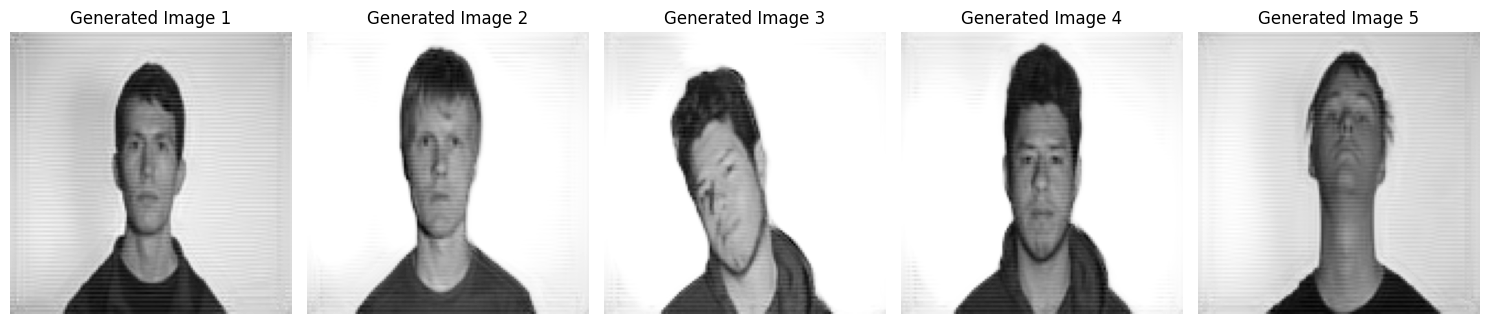

In [43]:
import matplotlib.pyplot as plt

num_samples = 5
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)  
    plt.imshow(generated_images_subset[i], cmap='gray' if generated_images_subset[i].shape[-1] == 1 else 'rgb')
    plt.title(f"Generated Image {i + 1}")
    plt.axis('off')  

plt.tight_layout()
plt.show()


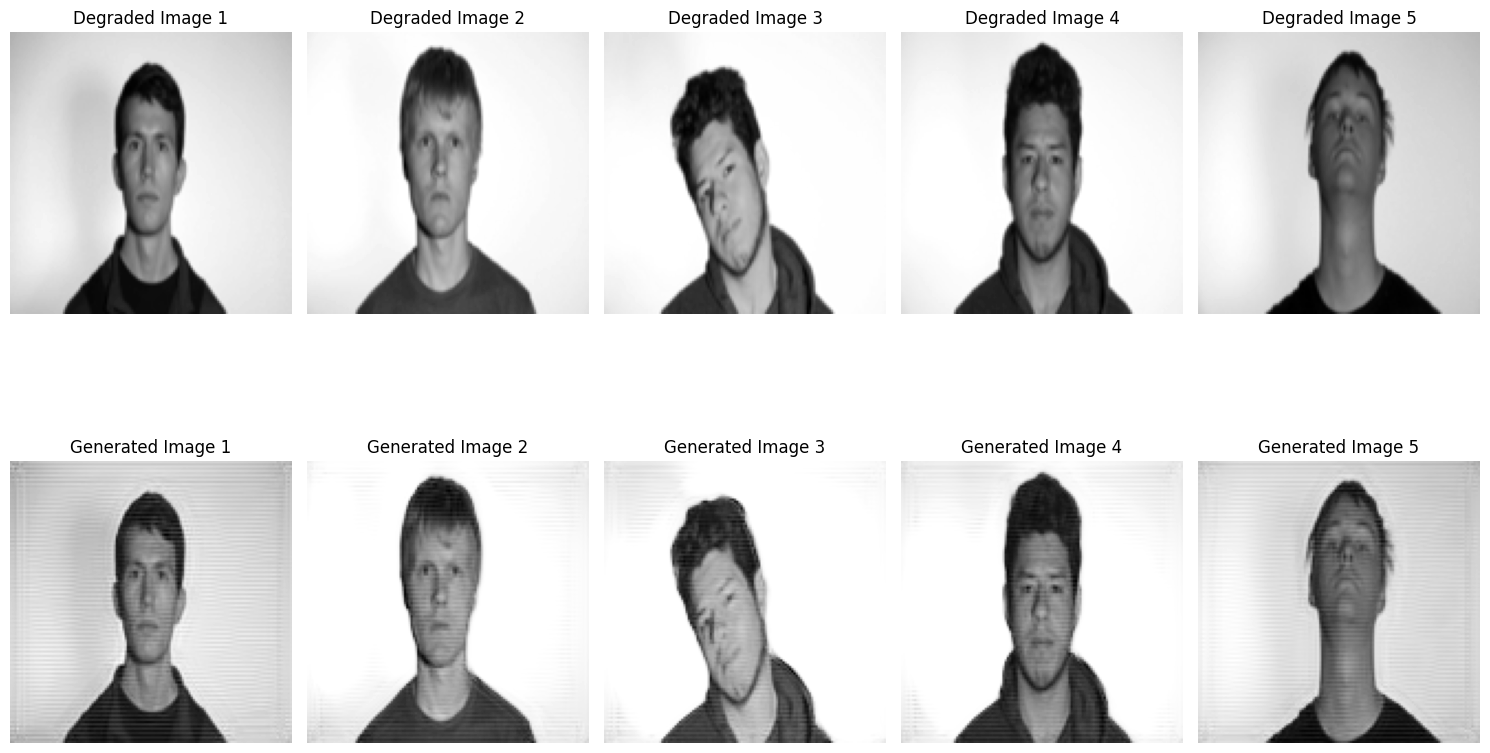

In [45]:
import matplotlib.pyplot as plt


num_samples = 5
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    
    plt.subplot(2, num_samples, i + 1)  
    plt.imshow(X_val[i], cmap='gray' if X_val[i].shape[-1] == 1 else 'rgb')
    plt.title(f"Degraded Image {i + 1}")
    plt.axis('off')  
    
   
    plt.subplot(2, num_samples, num_samples + i + 1)  
    plt.imshow(generated_images_subset[i], cmap='gray' if generated_images_subset[i].shape[-1] == 1 else 'rgb')
    plt.title(f"Generated Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [44]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr_values = []
ssim_values = []
for i in range(5):
    psnr = peak_signal_noise_ratio(x_val_subset[i], generated_images_subset[i], data_range=1.0)
    ssim = structural_similarity(x_val_subset[i], generated_images_subset[i], 
                                 multichannel=True, win_size=5, channel_axis=-1, data_range=1.0)
    psnr_values.append(psnr)
    ssim_values.append(ssim)

print("Average PSNR for 5 images:", sum(psnr_values) / len(psnr_values))
print("Average SSIM for 5 images:", sum(ssim_values) / len(ssim_values))


Average PSNR for 5 images: 32.38084745341142
Average SSIM for 5 images: 0.8609329104423523
